In [32]:
library("randomForestSRC")

library("qiime2R")
library("microbiome")
library("phyloseq")
library("tidyverse")
library("ggpmisc")
library("patchwork")
library("speedyseq")
library("microViz")

packageVersion("randomForestSRC")

In [34]:
#read metadata file and set factor order
meta = read.csv("/Users/stephanie.rosales/Documents/Tissueloss/EPA2/metadata/meta_EPA2.csv",
               header=TRUE, row.names=1)
meta$Site_Num <- as.integer(meta$Site_Num)
meta$Site.Status <- factor(meta$Site.Status, levels = c("Vulnerable",
                                                         "Epidemic","Endemic"))
head(meta, n=2)
dim(meta)

#read ASV table
ASV_qza <- read_qza("/Users/stephanie.rosales/Documents/Tissueloss/EPA2/merged_tables_BacArc_fill_EPA2.qza")
ASV_table <- ASV_qza$data
head(ASV_table, n=2)

dim(ASV_table)

#read taxa data
taxa_qza <- read_qza("/Users/stephanie.rosales/Documents/Tissueloss/EPA2/tax_EPA2.qza")
taxa_table <- taxa_qza$data
taxa_table <- taxa_qza$data %>%
as_tibble() %>% 
#select(-Confidence) %>% 
separate(Taxon, sep=";", c("Kingdom", "Phylum", "Class", "Order", "Family", "Genus", "Species")) %>%
arrange(Feature.ID) %>%
mutate(ASVs =paste('ASV',1:n(), sep = "_")) %>%
column_to_rownames("Feature.ID")%>%
as.matrix()

,samp,Sample.ID,Site,Site.Name,Region,Project,Objective,Type,Species_sample,Sample.Type,⋯,Types,Vul_coral,End_coral,Epi_coral,Vul_sed,End_sed,Epi_sed,Vul_wat,End_wat,Epi_wat
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
518.H,518.H_S18,518.H_S18,Site-G,Xesto.Patch,Lower Keys,SWG,cor,Coral,OFAV,Healthy,⋯,0,1,0,0,0,0,0,0,0,0
519.H,519.H_S18,519.H_S18,Site-G,Xesto.Patch,Lower Keys,SWG,cor,Coral,OFAV,Healthy,⋯,0,1,0,0,0,0,0,0,0,0


[1] 360  32

,R1.1.W,R1.10.W,R1.11.W,R1.12.W,R1.13.W,R1.14.W,R1.15.W,R1.16.W,R1.17.W,R1.18.W,⋯,GR.SINT.En4,GR.SINT.En5,GR.SINT.En6,TP.DLAB.En1,TP.DLAB.En2,TP.DLAB.En3,TP.DLAB.En4,TP.DLAB.En5,TP.DLAB.En6,TP.DSTO.En1
72caa013fe7649c65ffe72138ff7dfd1,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
2b248f10cca3c82a2640506132f9c869,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0


[1] 11756  1109

Warning message:
“Expected 7 pieces. Missing pieces filled with `NA` in 103262 rows [1, 2, 3, 7,
8, 9, 11, 12, 13, 14, 15, 16, 18, 19, 20, 21, 22, 24, 26, 27, ...].”


In [35]:
#read ASV table
ASV_qza <- read_qza("/Users/stephanie.rosales/Documents/Tissueloss/EPA2/merged_tables_BacArc_fill_EPA2.qza")
ASV_table <- ASV_qza$data
head(ASV_table, n=2)

dim(ASV_table)

,R1.1.W,R1.10.W,R1.11.W,R1.12.W,R1.13.W,R1.14.W,R1.15.W,R1.16.W,R1.17.W,R1.18.W,⋯,GR.SINT.En4,GR.SINT.En5,GR.SINT.En6,TP.DLAB.En1,TP.DLAB.En2,TP.DLAB.En3,TP.DLAB.En4,TP.DLAB.En5,TP.DLAB.En6,TP.DSTO.En1
72caa013fe7649c65ffe72138ff7dfd1,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
2b248f10cca3c82a2640506132f9c869,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0


[1] 11756  1109

In [36]:
ps = phyloseq(otu_table(ASV_table, taxa_are_rows=TRUE), 
               sample_data(meta),
tax_table(taxa_table))

ps %>% tax_fix()


phyloseq-class experiment-level object
otu_table()   OTU Table:          [ 11756 taxa and 360 samples ]:
sample_data() Sample Data:        [ 360 samples by 32 sample variables ]:
tax_table()   Taxonomy Table:     [ 11756 taxa by 9 taxonomic ranks ]:
taxa are rows

In [37]:
# Subset samples healthy and then by species
ps_AH <- subset_samples(ps, Sample.Type=="Healthy")

ps_ah_DSTO=subset_samples(ps_AH, Species_sample=="DSTO")
ps_ah_DSTO
ps_ah_SINT=subset_samples(ps_AH, Species_sample=="SINT")
ps_ah_SINT
ps_ah_MCAV=subset_samples(ps_AH, Species_sample=="MCAV")
ps_ah_MCAV
ps_ah_OFAV=subset_samples(ps_AH, Species_sample=="OFAV")
ps_ah_OFAV
ps_ah_PSTR=subset_samples(ps_AH, Species_sample=="PSTR")
ps_ah_PSTR

phyloseq-class experiment-level object
otu_table()   OTU Table:          [ 11756 taxa and 16 samples ]:
sample_data() Sample Data:        [ 16 samples by 32 sample variables ]:
tax_table()   Taxonomy Table:     [ 11756 taxa by 9 taxonomic ranks ]:
taxa are rows

phyloseq-class experiment-level object
otu_table()   OTU Table:          [ 11756 taxa and 17 samples ]:
sample_data() Sample Data:        [ 17 samples by 32 sample variables ]:
tax_table()   Taxonomy Table:     [ 11756 taxa by 9 taxonomic ranks ]:
taxa are rows

phyloseq-class experiment-level object
otu_table()   OTU Table:          [ 11756 taxa and 28 samples ]:
sample_data() Sample Data:        [ 28 samples by 32 sample variables ]:
tax_table()   Taxonomy Table:     [ 11756 taxa by 9 taxonomic ranks ]:
taxa are rows

phyloseq-class experiment-level object
otu_table()   OTU Table:          [ 11756 taxa and 29 samples ]:
sample_data() Sample Data:        [ 29 samples by 32 sample variables ]:
tax_table()   Taxonomy Table:     [ 11756 taxa by 9 taxonomic ranks ]:
taxa are rows

phyloseq-class experiment-level object
otu_table()   OTU Table:          [ 11756 taxa and 27 samples ]:
sample_data() Sample Data:        [ 27 samples by 32 sample variables ]:
tax_table()   Taxonomy Table:     [ 11756 taxa by 9 taxonomic ranks ]:
taxa are rows

In [38]:
#filter coral species to remove ASVs in low prevelenace 

ps_AH_fill = filter_taxa(ps_AH, function(x) sum(x > 5) > (0.1*length(x)), TRUE)
ps_AH_fill
ps_fill_dsto = filter_taxa(ps_ah_DSTO, function(x) sum(x > 5) > (0.1*length(x)), TRUE)
ps_fill_dsto
ps_fill_sint = filter_taxa(ps_ah_SINT, function(x) sum(x > 5) > (0.1*length(x)), TRUE)
ps_fill_sint
ps_fill_mcav = filter_taxa(ps_ah_MCAV, function(x) sum(x > 5) > (0.1*length(x)), TRUE)
ps_fill_mcav
ps_fill_ofav = filter_taxa(ps_ah_OFAV, function(x) sum(x > 5) > (0.1*length(x)), TRUE)
ps_fill_ofav               
ps_fill_pstr = filter_taxa(ps_ah_PSTR, function(x) sum(x > 5) > (0.1*length(x)), TRUE)
ps_fill_pstr  

phyloseq-class experiment-level object
otu_table()   OTU Table:          [ 915 taxa and 117 samples ]:
sample_data() Sample Data:        [ 117 samples by 32 sample variables ]:
tax_table()   Taxonomy Table:     [ 915 taxa by 9 taxonomic ranks ]:
taxa are rows

phyloseq-class experiment-level object
otu_table()   OTU Table:          [ 1427 taxa and 16 samples ]:
sample_data() Sample Data:        [ 16 samples by 32 sample variables ]:
tax_table()   Taxonomy Table:     [ 1427 taxa by 9 taxonomic ranks ]:
taxa are rows

phyloseq-class experiment-level object
otu_table()   OTU Table:          [ 2016 taxa and 17 samples ]:
sample_data() Sample Data:        [ 17 samples by 32 sample variables ]:
tax_table()   Taxonomy Table:     [ 2016 taxa by 9 taxonomic ranks ]:
taxa are rows

phyloseq-class experiment-level object
otu_table()   OTU Table:          [ 535 taxa and 28 samples ]:
sample_data() Sample Data:        [ 28 samples by 32 sample variables ]:
tax_table()   Taxonomy Table:     [ 535 taxa by 9 taxonomic ranks ]:
taxa are rows

phyloseq-class experiment-level object
otu_table()   OTU Table:          [ 805 taxa and 29 samples ]:
sample_data() Sample Data:        [ 29 samples by 32 sample variables ]:
tax_table()   Taxonomy Table:     [ 805 taxa by 9 taxonomic ranks ]:
taxa are rows

phyloseq-class experiment-level object
otu_table()   OTU Table:          [ 1222 taxa and 27 samples ]:
sample_data() Sample Data:        [ 27 samples by 32 sample variables ]:
tax_table()   Taxonomy Table:     [ 1222 taxa by 9 taxonomic ranks ]:
taxa are rows

In [39]:
set.seed(235033)
predictors <- t(otu_table(ps_AH_fill))

# Make one column for response variable 
response <- as.factor(sample_data(ps_AH_fill)$Site.Status)

# Combine them into data frame
rf.data <- data.frame(response, predictors)
head(rf.data, n=2)


coral.classify <- rfsrc(response~., data = rf.data, ntree = 500,
                     importance="permute", csv.num=TRUE, 
                        #cv.fold=3,
                        #splitrule = "auc" 
                        #strata=sample_data(ps_AH_fill)$Site.Status
                       )
coral.classify

tax_coral=cbind(as.data.frame(coral.classify$importance), as.data.frame(tax_table(ps_AH_fill))) %>%
arrange(-all) #%>%
#head(n=10)
head(tax_coral)


,response,X4af34e31f4f29f5372246db273985eb8,X3da2ced63ab908b7a3be96b147e3004a,f71e8be5ffefd9c56af594b2a42ea17c,X6d5a010f72f3f1199973aaa7ec9c4164,f5d7ec18156c74db93a21bd1261e8f78,X4585df1e50203920024dd9be21f59bee,X8142d72fba413c027a2274cd08385427,X572f06c3cc65f3e95ef57f05acfea074,X72afc9a76e86ea398c2fa3cf88692d5a,⋯,dfaf458ae310d6c4203e6b6d039265d0,abd5f1fa8719656e2a17b7a190d75593,X8ad23b91445141f434416d07d2b1dc42,X2ac0e6fa85039f2f0ead04c6d2f09887,X453d7372eebb15b369aba6493f4e9173,X0e2e91fba1ca9ed7de2d11ea4786c914,X7ff06598e9fd07d55722b20b137d9078,c31a1c07a147e95339be9f03130553a9,X0f990cf2a8b22a105f2c439e9b7576c1,X8e844cd3303efc5bbb4917b26c106900
,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
R3S7A1,Vulnerable,47,0,0,0,0,18,0,0,36,⋯,0,48,61,0,0,0,10,0,4,0
R3S7A2,Vulnerable,21,0,0,0,4,0,0,5,0,⋯,0,26,33,0,58,0,0,0,0,0


                         Sample size: 117
           Frequency of class labels: 27, 42, 48
                     Number of trees: 500
           Forest terminal node size: 1
       Average no. of terminal nodes: 10.9
No. of variables tried at each split: 31
              Total no. of variables: 915
       Resampling used to grow trees: swor
    Resample size used to grow trees: 74
                            Analysis: RF-C
                              Family: class
                      Splitting rule: gini *random*
       Number of random split points: 10
                   (OOB) Brier score: 0.03010263
        (OOB) Normalized Brier score: 0.13546185
                           (OOB) AUC: 1
                      (OOB) Log-loss: 0.23625515
   (OOB) Requested performance error: 0.01709402, 0.03703704, 0.02380952, 0

Confusion matrix:

            predicted
  observed   Vulnerable Epidemic Endemic class.error
  Vulnerable         26        0       1      0.0370
  Epidemic            0   

,all,Vulnerable,Epidemic,Endemic,Kingdom,Phylum,Class,Order,Family,Genus,Species,Confidence,ASVs
,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
c16867ce7333b2d66e679f20c672b760,0.020766175,0.06644689,6.730984e-02,0.039641610,d__Bacteria,p__Bacteroidota,c__Bacteroidia,o__Flavobacteriales,f__Flavobacteriaceae,g__NS4_marine_group,s__uncultured_Flavobacteriaceae,0.8144295,ASV_111371
X0920dcf0f62fb2b3ab9e32f1c4edec37,0.014167481,0.14900212,-6.035798e-18,0.009060939,d__Bacteria,p__Proteobacteria,c__Gammaproteobacteria,o__Burkholderiales,f__Comamonadaceae,NA,NA,0.9992587,ASV_5399
a5f208587e914e3c16310ef23c43bf87,0.012425165,0.13692086,-2.588840e-03,0.006795705,d__Bacteria,p__Bacteroidota,c__Bacteroidia,o__Sphingobacteriales,f__NS11-12_marine_group,g__NS11-12_marine_group,s__unidentified_marine,0.9892718,ASV_95517
f47ce36f26232249e2ff2e488ba48bd0,0.010896040,0.12081253,1.294420e-03,0.002265235,d__Bacteria,p__Bacteroidota,c__Bacteroidia,o__Sphingobacteriales,f__NS11-12_marine_group,g__NS11-12_marine_group,NA,0.9998546,ASV_141001
b8a5a874a00188de53bdd033791f917f,0.009122159,0.01610834,4.012702e-02,0.015856644,d__Bacteria,p__Bacteroidota,c__Bacteroidia,o__Flavobacteriales,f__Flavobacteriaceae,g__uncultured,NA,0.7700485,ASV_106211
X3a5bed6f33492b43dbe33e2aefdc8e36,0.008475728,0.01409479,3.236050e-02,0.019254496,d__Bacteria,p__Bacteroidota,c__Bacteroidia,o__Cytophagales,f__Cyclobacteriaceae,g__Marinoscillum,s__marine_metagenome,0.9671389,ASV_33524


In [40]:
#write.csv(as.data.frame(coral.classify$importance), "/Users//stephanie.rosales//Documents/Tissueloss/EPA2//Figures/coral_Rf.csv")

In [41]:

# Create a list to store the results
result_list <- list()

# Define the column names for sorting
sort_columns <- c("Vulnerable", "Endemic", "Epidemic")

# Loop through the sorting columns
for (col in sort_columns) {
  result <- cbind(as.data.frame(coral.classify$importance), as.data.frame(tax_table(ps_AH_fill))) %>%
    arrange(desc(get(col))) %>%
    head(n = 10) %>%
    distinct()  # Remove duplicate rows
  
  # Add the Site.Status column
  result$Site.Status <- col
  
  # Add the value column
  result$variable <- head(result[, col], 10)
   # Add the Type column
  result$Type <- "Coral"
  
  # Assign the result to the list
  result_list[[paste0(col, "_5")]] <- result
}

# Combine the results into a single data frame
rf_coral_df <- do.call(rbind, result_list)

head(rf_coral_df)


,all,Vulnerable,Epidemic,Endemic,Kingdom,Phylum,Class,Order,Family,Genus,Species,Confidence,ASVs,Site.Status,variable,Type
,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>
Vulnerable_5.X0920dcf0f62fb2b3ab9e32f1c4edec37,0.014167481,0.14900212,-6.035798e-18,0.009060939,d__Bacteria,p__Proteobacteria,c__Gammaproteobacteria,o__Burkholderiales,f__Comamonadaceae,NA,NA,0.9992587,ASV_5399,Vulnerable,0.14900212,Coral
Vulnerable_5.a5f208587e914e3c16310ef23c43bf87,0.012425165,0.13692086,-2.588840e-03,0.006795705,d__Bacteria,p__Bacteroidota,c__Bacteroidia,o__Sphingobacteriales,f__NS11-12_marine_group,g__NS11-12_marine_group,s__unidentified_marine,0.9892718,ASV_95517,Vulnerable,0.13692086,Coral
Vulnerable_5.f47ce36f26232249e2ff2e488ba48bd0,0.010896040,0.12081253,1.294420e-03,0.002265235,d__Bacteria,p__Bacteroidota,c__Bacteroidia,o__Sphingobacteriales,f__NS11-12_marine_group,g__NS11-12_marine_group,NA,0.9998546,ASV_141001,Vulnerable,0.12081253,Coral
Vulnerable_5.c16867ce7333b2d66e679f20c672b760,0.020766175,0.06644689,6.730984e-02,0.039641610,d__Bacteria,p__Bacteroidota,c__Bacteroidia,o__Flavobacteriales,f__Flavobacteriaceae,g__NS4_marine_group,s__uncultured_Flavobacteriaceae,0.8144295,ASV_111371,Vulnerable,0.06644689,Coral
Vulnerable_5.faf1029d37956293b35d5c395a5297c1,0.007096444,0.06443335,1.294420e-02,-0.001132617,d__Bacteria,p__Cyanobacteria,c__Cyanobacteriia,o__Synechococcales,f__Cyanobiaceae,g__Cyanobium_PCC-6307,NA,0.9227289,ASV_144743,Vulnerable,0.06443335,Coral
Vulnerable_5.fae58f96e2b2cb6910a2ada15c399b8e,0.003448481,0.03825730,3.883260e-03,-0.002265235,d__Bacteria,p__Proteobacteria,c__Gammaproteobacteria,o__Salinisphaerales,f__Salinisphaeraceae,g__Salinisphaera,NA,0.9998654,ASV_144712,Vulnerable,0.03825730,Coral


In [43]:
# Subset samples for Sediment type
ps_Sediment <- subset_samples(ps, subset = sample_data(ps)$Type == "Sediment")

ps_fill_s = filter_taxa(ps_Sediment, function(x) sum(x > 5) > (0.1*length(x)), TRUE)
ps_fill_s

ps_Water <- subset_samples(ps, subset = sample_data(ps)$Type == "Water")

ps_fill_w = filter_taxa(ps_Water, function(x) sum(x > 5) > (0.1*length(x)), TRUE)
ps_fill_w

phyloseq-class experiment-level object
otu_table()   OTU Table:          [ 4389 taxa and 90 samples ]:
sample_data() Sample Data:        [ 90 samples by 32 sample variables ]:
tax_table()   Taxonomy Table:     [ 4389 taxa by 9 taxonomic ranks ]:
taxa are rows

phyloseq-class experiment-level object
otu_table()   OTU Table:          [ 940 taxa and 96 samples ]:
sample_data() Sample Data:        [ 96 samples by 32 sample variables ]:
tax_table()   Taxonomy Table:     [ 940 taxa by 9 taxonomic ranks ]:
taxa are rows

In [44]:
set.seed(235033)
predictors <- t(otu_table(ps_fill_s))

# Make one column for response variable 
response <- as.factor(sample_data(ps_fill_s)$Site.Status)

# Combine them into data frame
rf.data <- data.frame(response, predictors)
head(rf.data, n=2)


sed.classify <- rfsrc(response~., data = rf.data, ntree = 500,
                     importance="permute", csv.num=TRUE)
sed.classify

tax_sed=cbind(as.data.frame(sed.classify$importance), as.data.frame(tax_table(ps_fill_s))) %>%
arrange(-all) %>%
head(n=10)

tax_sed

,response,X4af34e31f4f29f5372246db273985eb8,f3565d0f24fa37db9d1577980c241ab8,X9e92e6c0dfbd189c0e240e6184124632,X22a7c4fa30216abc86e742ee0117c410,X543999d1b4884acefb025de86fac0459,ad36b51916f335f19e6571e81a94c188,X89f5e841fc125e244c88d9685c8da045,X938eac374f8d972582590e892bc9319d,a66a2f862ed958654d5df7a2a2a46625,⋯,X46d3ea2caf44971207051a77b98e3d14,X8e844cd3303efc5bbb4917b26c106900,X9e662b95c94dcdeb4a66b108d8de1c5b,b92881aac441b24a752f98fe36d058d8,c473df0d620f525669c30723084c5ae5,e8fce42ab53adb3687fb6da7f711d98f,X47469c6349722f505954967c6348c752,cb2ce72d49285989f12279a962d80a76,ba2f196ebaf40e40a61e9436051457fe,X3f870e84e30743caf6fa3468783211bf
,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
R3.1.S,Vulnerable,42,150,0,11,0,0,0,0,0,⋯,0,0,0,0,6,0,0,0,0,0
R3.10.S,Vulnerable,82,0,0,12,0,14,0,0,0,⋯,24,0,0,0,9,0,15,0,0,12


                         Sample size: 90
           Frequency of class labels: 30, 30, 30
                     Number of trees: 500
           Forest terminal node size: 1
       Average no. of terminal nodes: 7.004
No. of variables tried at each split: 67
              Total no. of variables: 4389
       Resampling used to grow trees: swor
    Resample size used to grow trees: 57
                            Analysis: RF-C
                              Family: class
                      Splitting rule: gini *random*
       Number of random split points: 10
                   (OOB) Brier score: 0.02946842
        (OOB) Normalized Brier score: 0.13260791
                           (OOB) AUC: 0.99851852
                      (OOB) Log-loss: 0.21039466
   (OOB) Requested performance error: 0.01111111, 0, 0, 0.03333333

Confusion matrix:

            predicted
  observed   Vulnerable Epidemic Endemic class.error
  Vulnerable         30        0       0      0.0000
  Epidemic            0  

,all,Vulnerable,Epidemic,Endemic,Kingdom,Phylum,Class,Order,Family,Genus,Species,Confidence,ASVs
,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
bd53e2483c985a090089d93fc039c4ac,0.011313607,0.003624376,0.06523876,0.021746255,d__Bacteria,p__Proteobacteria,c__Alphaproteobacteria,o__Rickettsiales,f__Fokiniaceae,g__MD3-55,NA,0.9999999,ASV_108998
X30034694309aad8d9fce419a0e14ed8a,0.010342699,0.007248752,0.05255345,0.023558443,d__Bacteria,p__Bacteroidota,c__Bacteroidia,o__Flavobacteriales,f__Flavobacteriaceae,g__Maritimimonas,s__uncultured_Flavobacteriaceae,0.9583244,ASV_27636
X93d599229f1b55f21eec84519bd4807f,0.010289808,0.021746255,0.04711689,0.014497503,d__Bacteria,p__Proteobacteria,c__Alphaproteobacteria,o__Rhodospirillales,f__AEGEAN-169_marine_group,g__AEGEAN-169_marine_group,NA,0.9999980,ASV_85025
X9d4f5e1ddfe27972a3be6d89f377f8b2,0.008325624,0.005436564,0.03986813,0.021746255,d__Bacteria,p__Proteobacteria,c__Gammaproteobacteria,o__Steroidobacterales,f__Woeseiaceae,g__Woeseia,NA,0.8374410,ASV_90521
X77698bb44fb8aca834066fff2d645cc1,0.007033982,0.012685315,0.03443157,0.009060939,d__Bacteria,p__Proteobacteria,c__Gammaproteobacteria,o__Steroidobacterales,f__Woeseiaceae,g__Woeseia,NA,0.9306320,ASV_68711
X43bf2e05902a9f38eb400647f5b1e0a0,0.005833106,0.001812188,0.03443157,0.010873127,d__Bacteria,p__Proteobacteria,c__Gammaproteobacteria,o__Vibrionales,f__Vibrionaceae,g__Vibrio,NA,0.9277335,ASV_38772
c43c425b27aff58fb1227673f21d9403,0.005406486,0.012685315,0.02355844,0.007248752,d__Bacteria,p__Proteobacteria,c__Gammaproteobacteria,o__SAR86_clade,f__SAR86_clade,g__SAR86_clade,NA,0.9999985,ASV_113011
b804475fcfa81a29cfc6cd05a0c85742,0.005171263,0.000000000,0.03080719,0.010873127,d__Bacteria,p__Proteobacteria,c__Gammaproteobacteria,o__Steroidobacterales,f__Woeseiaceae,g__Woeseia,NA,0.8777428,ASV_105839
dfee0dfd8c86415a8c8e28784f482990,0.004728042,0.021746255,0.01268532,0.003624376,d__Bacteria,p__Bacteroidota,c__Bacteroidia,o__Flavobacteriales,f__Cryomorphaceae,g__uncultured,NA,0.9999715,ASV_129169


In [45]:
#write.csv(as.data.frame(sed.classify$importance), "/Users//stephanie.rosales//Documents/Tissueloss/EPA2//Figures/sed_Rf.csv")

In [46]:
# Create a list to store the results
result_list <- list()

# Define the column names for sorting
sort_columns <- c("Vulnerable", "Endemic", "Epidemic")

# Loop through the sorting columns
for (col in sort_columns) {
  result <- cbind(as.data.frame(sed.classify$importance), as.data.frame(tax_table(ps_fill_s))) %>%
    arrange(desc(get(col))) %>%
    head(n = 10) %>%
    distinct()  # Remove duplicate rows
  
  # Add the Site.Status column
  result$Site.Status <- col
  
  # Add the value column
  result$variable <- head(result[, col], 10)
   # Add the Type column
  result$Type <- "Sediment"
  
  # Assign the result to the list
  result_list[[paste0(col, "_5")]] <- result
}

# Combine the results into a single data frame
rf_sed_df <- do.call(rbind, result_list)

rf_sed_df


,all,Vulnerable,Epidemic,Endemic,Kingdom,Phylum,Class,Order,Family,Genus,Species,Confidence,ASVs,Site.Status,variable,Type
,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>
Vulnerable_5.X055b24a8fe7d19c339268f5e3b344a85,0.004539142,0.027182818,7.248752e-03,0.001812188,d__Bacteria,p__Proteobacteria,c__Alphaproteobacteria,o__Rhodobacterales,f__Rhodobacteraceae,NA,NA,0.9995432,ASV_3184,Vulnerable,0.02718282,Sediment
Vulnerable_5.X2409d1e0d64fc5430bdc151c9d760508,0.003139150,0.025370630,1.812188e-03,-0.001812188,d__Bacteria,p__Bacteroidota,c__Bacteroidia,o__Sphingobacteriales,f__NS11-12_marine_group,g__NS11-12_marine_group,s__uncultured_marine,0.7234735,ASV_20725,Vulnerable,0.02537063,Sediment
Vulnerable_5.a9a516691d10b9beb2649fa7d5782c36,0.003825853,0.023558443,5.436564e-03,0.001812188,d__Bacteria,p__Actinobacteriota,c__Actinobacteria,o__Micrococcales,f__Microbacteriaceae,NA,NA,0.9998503,ASV_97598,Vulnerable,0.02355844,Sediment
Vulnerable_5.X1dd61e9e3a216879b157f7a0032406f2,0.003365906,0.023558443,3.624376e-03,0.000000000,d__Bacteria,p__Proteobacteria,c__Gammaproteobacteria,o__Oceanospirillales,f__Litoricolaceae,g__Litoricola,NA,0.9999365,ASV_17134,Vulnerable,0.02355844,Sediment
Vulnerable_5.X4efd665bb1396ec3855158db4eefef12,0.004479571,0.023558443,7.248752e-03,0.005436564,d__Bacteria,p__Proteobacteria,c__Gammaproteobacteria,NA,NA,NA,NA,0.9974359,ASV_45155,Vulnerable,0.02355844,Sediment
Vulnerable_5.d4203fbdb8a8bc6e83ce9610921891e5,0.003573034,0.021746255,1.812188e-03,0.005436564,d__Bacteria,p__Proteobacteria,c__Gammaproteobacteria,o__Oceanospirillales,f__Litoricolaceae,g__Litoricola,NA,0.9979141,ASV_122395,Vulnerable,0.02174625,Sediment
Vulnerable_5.X93d599229f1b55f21eec84519bd4807f,0.010289808,0.021746255,4.711689e-02,0.014497503,d__Bacteria,p__Proteobacteria,c__Alphaproteobacteria,o__Rhodospirillales,f__AEGEAN-169_marine_group,g__AEGEAN-169_marine_group,NA,0.9999980,ASV_85025,Vulnerable,0.02174625,Sediment
Vulnerable_5.dfee0dfd8c86415a8c8e28784f482990,0.004728042,0.021746255,1.268532e-02,0.003624376,d__Bacteria,p__Bacteroidota,c__Bacteroidia,o__Flavobacteriales,f__Cryomorphaceae,g__uncultured,NA,0.9999715,ASV_129169,Vulnerable,0.02174625,Sediment
Vulnerable_5.X5664494145a6098c00ced4e2ff376b34,0.004484451,0.019934067,9.060939e-03,0.007248752,d__Bacteria,p__Proteobacteria,c__Gammaproteobacteria,o__Ectothiorhodospirales,f__Ectothiorhodospiraceae,g__uncultured,s__uncultured_marine,0.9972481,ASV_49480,Vulnerable,0.01993407,Sediment


In [47]:
ps_fill_w

phyloseq-class experiment-level object
otu_table()   OTU Table:          [ 940 taxa and 96 samples ]:
sample_data() Sample Data:        [ 96 samples by 32 sample variables ]:
tax_table()   Taxonomy Table:     [ 940 taxa by 9 taxonomic ranks ]:
taxa are rows

In [48]:
set.seed(235033)
predictors <- t(otu_table(ps_fill_w))

# Make one column for response variable 
response <- as.factor(sample_data(ps_fill_w)$Site.Status)

# Combine them into data frame
rf.data <- data.frame(response, predictors)
head(rf.data, n=2)


wat.classify <- rfsrc(response~., data = rf.data, ntree = 500,
                     importance="permute", csv.num=TRUE)
wat.classify

tax_wat=cbind(as.data.frame(wat.classify$importance), as.data.frame(tax_table(ps_fill_w))) %>%
arrange(-all) %>%
head(n=10)

tax_wat

,response,X4af34e31f4f29f5372246db273985eb8,X516a7dfb3358a03ad54608b2bfe54ded,X3da2ced63ab908b7a3be96b147e3004a,f71e8be5ffefd9c56af594b2a42ea17c,X5a5ab5cd4147dd3453222050616e6280,X6d5a010f72f3f1199973aaa7ec9c4164,X8142d72fba413c027a2274cd08385427,X62e27bf703d5b58ef91a16321f08bbf0,f8198e3bdcea5dd4fe0813a5c09c36e8,⋯,abd5f1fa8719656e2a17b7a190d75593,X22d41ee795d550e73ae18d88ca12db1c,X8ad23b91445141f434416d07d2b1dc42,cb8cd330a6d7e568f9987ff31ab55c7f,X474b7f416c91963c155d84807829f8c2,X2ac0e6fa85039f2f0ead04c6d2f09887,X4fa7435c970ac3030d658f8739297570,c31a1c07a147e95339be9f03130553a9,f476582898cac3e28476a4b7d995e92f,X0984a1fd323dbe0111d2a5304cd2ad66
,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
R3.1.W,Vulnerable,8,0,0,0,134,8,0,0,0,⋯,240,0,0,0,0,0,0,0,0,0
R3.10.W,Vulnerable,0,0,0,0,8,0,0,0,0,⋯,447,0,0,0,0,0,60,0,0,0


                         Sample size: 96
           Frequency of class labels: 36, 30, 30
                     Number of trees: 500
           Forest terminal node size: 1
       Average no. of terminal nodes: 4.834
No. of variables tried at each split: 31
              Total no. of variables: 940
       Resampling used to grow trees: swor
    Resample size used to grow trees: 61
                            Analysis: RF-C
                              Family: class
                      Splitting rule: gini *random*
       Number of random split points: 10
                   (OOB) Brier score: 0.00548403
        (OOB) Normalized Brier score: 0.02467814
                           (OOB) AUC: 1
                      (OOB) Log-loss: 0.07612368
   (OOB) Requested performance error: 0, 0, 0, 0

Confusion matrix:

            predicted
  observed   Vulnerable Epidemic Endemic class.error
  Vulnerable         36        0       0           0
  Epidemic            0       30       0           0


,all,Vulnerable,Epidemic,Endemic,Kingdom,Phylum,Class,Order,Family,Genus,Species,Confidence,ASVs
,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
e9c6bebb09f862b76f5853ea328fe31d,0.006535794,0.013591409,0.032619382,0.007248752,d__Archaea,p__Thermoplasmatota,c__Thermoplasmata,o__Marine_Group_II,f__Marine_Group_II,g__Marine_Group_II,NA,1.0000000,ASV_134829
a765495a981deabd2c70f9e666408aa3,0.006316682,0.001510157,0.047116885,0.005436564,d__Bacteria,p__Proteobacteria,c__Alphaproteobacteria,o__Rhodobacterales,f__Rhodobacteraceae,NA,NA,0.9999648,ASV_96345
X3ee2e430d29fe718a63944d48f67640a,0.006092528,0.003020313,0.043492509,0.005436564,d__Bacteria,p__Proteobacteria,c__Gammaproteobacteria,o__Coxiellales,f__Coxiellaceae,g__Coxiella,s__uncultured_Legionellales,0.8287021,ASV_36076
X44d6a1ba6d89866184a1c0947fd26d99,0.005675719,0.006040626,0.023558443,0.018121879,d__Bacteria,p__Proteobacteria,c__Gammaproteobacteria,o__Coxiellales,f__Coxiellaceae,g__Coxiella,s__uncultured_marine,0.9709127,ASV_39380
X6939bd3f23555d5130dcf8c233c9450b,0.005445315,0.004530470,0.036243758,0.005436564,d__Bacteria,p__Proteobacteria,c__Gammaproteobacteria,o__Coxiellales,f__Coxiellaceae,g__Coxiella,NA,0.9631521,ASV_60341
X35eada3386f22f193f98be8c0b6d88c8,0.005445269,0.004530470,0.025370630,0.016309691,d__Bacteria,p__Proteobacteria,c__Alphaproteobacteria,o__SAR11_clade,f__Clade_I,g__Clade_Ia,NA,0.8123505,ASV_30980
X9cdadd8a7359a3163fb31ad06be74e8c,0.004846865,0.021142192,0.014497503,0.001812188,d__Archaea,p__Thermoplasmatota,c__Thermoplasmata,o__Marine_Group_II,f__Marine_Group_II,g__Marine_Group_II,NA,1.0000000,ASV_90264
bc61e8b42af604e9c8858af057bfece9,0.004842245,0.007550783,0.014497503,0.018121879,d__Bacteria,NA,NA,NA,NA,NA,NA,0.8137339,ASV_108430
f5b2e70217cc44b43a423ebc8609a4af,0.004840383,0.024162505,0.005436564,0.007248752,d__Bacteria,p__Proteobacteria,c__Alphaproteobacteria,o__SAR11_clade,f__Clade_II,g__Clade_II,s__unidentified_marine,0.7333972,ASV_141729


In [49]:
#write.csv(as.data.frame(wat.classify$importance), "/Users//stephanie.rosales//Documents/Tissueloss/EPA2//Figures/wat_Rf.csv")

In [50]:
# Create a list to store the results
result_list <- list()

# Define the column names for sorting
sort_columns <- c("Vulnerable", "Endemic", "Epidemic")

# Loop through the sorting columns
for (col in sort_columns) {
  result <- cbind(as.data.frame(wat.classify$importance), as.data.frame(tax_table(ps_fill_w))) %>%
    arrange(desc(get(col))) %>%
    head(n = 10) %>%
    distinct()  # Remove duplicate rows
  
  # Add the Site.Status column
  result$Site.Status <- col
  
  # Add the value column
  result$variable <- head(result[, col], 10)
   # Add the Type column
  result$Type <- "Water"
  
  # Assign the result to the list
  result_list[[paste0(col, "_5")]] <- result
}

# Combine the results into a single data frame
rf_wat_df <- do.call(rbind, result_list)

rf_wat_df


,all,Vulnerable,Epidemic,Endemic,Kingdom,Phylum,Class,Order,Family,Genus,Species,Confidence,ASVs,Site.Status,variable,Type
,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>
Vulnerable_5.f07742b99196a9dd9416e1deba413b7c,0.004397023,0.024162505,0.001812188,0.007248752,d__Bacteria,p__Proteobacteria,c__Alphaproteobacteria,o__Parvibaculales,f__OCS116_clade,g__OCS116_clade,NA,0.9999859,ASV_138680,Vulnerable,0.024162505,Water
Vulnerable_5.X7ff01908e1d8d187672c7dbc4ecdd0ec,0.004419140,0.024162505,0.003624376,0.005436564,d__Archaea,p__Thermoplasmatota,c__Thermoplasmata,o__Marine_Group_II,f__Marine_Group_II,g__Marine_Group_II,NA,1.0000000,ASV_73703,Vulnerable,0.024162505,Water
Vulnerable_5.X0959c6e567d6cc4b8f5d94ce1c525642,0.003783035,0.024162505,0.001812188,0.001812188,d__Bacteria,p__Proteobacteria,c__Gammaproteobacteria,o__SAR86_clade,f__SAR86_clade,g__SAR86_clade,NA,0.9929668,ASV_5514,Vulnerable,0.024162505,Water
Vulnerable_5.f5b2e70217cc44b43a423ebc8609a4af,0.004840383,0.024162505,0.005436564,0.007248752,d__Bacteria,p__Proteobacteria,c__Alphaproteobacteria,o__SAR11_clade,f__Clade_II,g__Clade_II,s__unidentified_marine,0.7333972,ASV_141729,Vulnerable,0.024162505,Water
Vulnerable_5.c464817f47c18d57283ed2bddce0e10a,0.003989035,0.021142192,0.009060939,0.000000000,d__Bacteria,p__Proteobacteria,c__Alphaproteobacteria,o__SAR11_clade,f__Clade_I,g__Clade_Ib,NA,0.9079918,ASV_113103,Vulnerable,0.021142192,Water
Vulnerable_5.X9cdadd8a7359a3163fb31ad06be74e8c,0.004846865,0.021142192,0.014497503,0.001812188,d__Archaea,p__Thermoplasmatota,c__Thermoplasmata,o__Marine_Group_II,f__Marine_Group_II,g__Marine_Group_II,NA,1.0000000,ASV_90264,Vulnerable,0.021142192,Water
Vulnerable_5.X57371e5644fa2cc11934909026c8e908,0.002934352,0.019632035,0.000000000,0.001812188,d__Bacteria,p__Proteobacteria,c__Alphaproteobacteria,o__SAR11_clade,f__Clade_III,g__Clade_III,NA,1.0000000,ASV_49981,Vulnerable,0.019632035,Water
Vulnerable_5.a5f208587e914e3c16310ef23c43bf87,0.002932018,0.019632035,0.000000000,0.001812188,d__Bacteria,p__Bacteroidota,c__Bacteroidia,o__Sphingobacteriales,f__NS11-12_marine_group,g__NS11-12_marine_group,s__unidentified_marine,0.9892718,ASV_95517,Vulnerable,0.019632035,Water
Vulnerable_5.X649e8e5cbf452134d7fa0ba96f43d049,0.003774123,0.019632035,0.001812188,0.007248752,d__Bacteria,p__Bacteroidota,c__Bacteroidia,o__Flavobacteriales,f__Flavobacteriaceae,g__NS5_marine_group,NA,0.9853357,ASV_57692,Vulnerable,0.019632035,Water


In [51]:
rf_all <- rbind(rf_wat_df, rf_sed_df, rf_coral_df)
tail(rf_all)
head(rf_all)
dim(rf_all)

,all,Vulnerable,Epidemic,Endemic,Kingdom,Phylum,Class,Order,Family,Genus,Species,Confidence,ASVs,Site.Status,variable,Type
,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>
Epidemic_5.X3a5bed6f33492b43dbe33e2aefdc8e36,0.008475728,0.01409479,0.03236050,0.019254496,d__Bacteria,p__Bacteroidota,c__Bacteroidia,o__Cytophagales,f__Cyclobacteriaceae,g__Marinoscillum,s__marine_metagenome,0.9671389,ASV_33524,Epidemic,0.03236050,Coral
Epidemic_5.X76c75b6950ce069329a6c41d2c7527ed,0.006573024,0.02416251,0.02588840,0.006795705,d__Bacteria,p__Actinobacteriota,c__Acidimicrobiia,o__Microtrichales,f__Microtrichaceae,g__Sva0996_marine_group,s__uncultured_Verrucomicrobiales,0.9909469,ASV_68328,Epidemic,0.02588840,Coral
Epidemic_5.X692acb00d5891421d5d569cbf41e9e30,0.006767827,0.03020313,0.02588840,0.004530470,d__Bacteria,p__Bacteroidota,c__Bacteroidia,o__Flavobacteriales,f__NS9_marine_group,g__NS9_marine_group,NA,0.8568259,ASV_60305,Epidemic,0.02588840,Coral
Epidemic_5.fa92f339285b4a52cd29183cbc595aee,0.004669055,0.01610834,0.02200514,0.002265235,d__Bacteria,p__Proteobacteria,c__Alphaproteobacteria,o__Rhodobacterales,f__Rhodobacteraceae,NA,NA,0.9953607,ASV_144531,Epidemic,0.02200514,Coral
Epidemic_5.X1219316521169aa7d8fa7e220ffeb483,0.005531174,0.02013542,0.02200514,0.005663087,d__Bacteria,p__Firmicutes,c__Clostridia,o__Peptostreptococcales-Tissierellales,f__Peptostreptococcaceae,g__Tepidibacter,s__Tepidibacter_mesophilus,0.8460252,ASV_10465,Epidemic,0.02200514,Coral
Epidemic_5.X29899acf045c283c5e65ac8381b48787,0.004663005,0.01409479,0.02200514,0.003397852,d__Bacteria,p__Bacteroidota,c__Bacteroidia,o__Flavobacteriales,f__Flavobacteriaceae,g__NS4_marine_group,NA,0.9966746,ASV_23878,Epidemic,0.02200514,Coral


,all,Vulnerable,Epidemic,Endemic,Kingdom,Phylum,Class,Order,Family,Genus,Species,Confidence,ASVs,Site.Status,variable,Type
,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>
Vulnerable_5.f07742b99196a9dd9416e1deba413b7c,0.004397023,0.02416251,0.001812188,0.007248752,d__Bacteria,p__Proteobacteria,c__Alphaproteobacteria,o__Parvibaculales,f__OCS116_clade,g__OCS116_clade,NA,0.9999859,ASV_138680,Vulnerable,0.02416251,Water
Vulnerable_5.X7ff01908e1d8d187672c7dbc4ecdd0ec,0.004419140,0.02416251,0.003624376,0.005436564,d__Archaea,p__Thermoplasmatota,c__Thermoplasmata,o__Marine_Group_II,f__Marine_Group_II,g__Marine_Group_II,NA,1.0000000,ASV_73703,Vulnerable,0.02416251,Water
Vulnerable_5.X0959c6e567d6cc4b8f5d94ce1c525642,0.003783035,0.02416251,0.001812188,0.001812188,d__Bacteria,p__Proteobacteria,c__Gammaproteobacteria,o__SAR86_clade,f__SAR86_clade,g__SAR86_clade,NA,0.9929668,ASV_5514,Vulnerable,0.02416251,Water
Vulnerable_5.f5b2e70217cc44b43a423ebc8609a4af,0.004840383,0.02416251,0.005436564,0.007248752,d__Bacteria,p__Proteobacteria,c__Alphaproteobacteria,o__SAR11_clade,f__Clade_II,g__Clade_II,s__unidentified_marine,0.7333972,ASV_141729,Vulnerable,0.02416251,Water
Vulnerable_5.c464817f47c18d57283ed2bddce0e10a,0.003989035,0.02114219,0.009060939,0.000000000,d__Bacteria,p__Proteobacteria,c__Alphaproteobacteria,o__SAR11_clade,f__Clade_I,g__Clade_Ib,NA,0.9079918,ASV_113103,Vulnerable,0.02114219,Water
Vulnerable_5.X9cdadd8a7359a3163fb31ad06be74e8c,0.004846865,0.02114219,0.014497503,0.001812188,d__Archaea,p__Thermoplasmatota,c__Thermoplasmata,o__Marine_Group_II,f__Marine_Group_II,g__Marine_Group_II,NA,1.0000000,ASV_90264,Vulnerable,0.02114219,Water


[1] 90 16

In [52]:
duplicate_columns <- names(rf_all[duplicated(names(rf_all))])

# Print duplicate column names
print(duplicate_columns)

character(0)


## Suplemental Figure 2

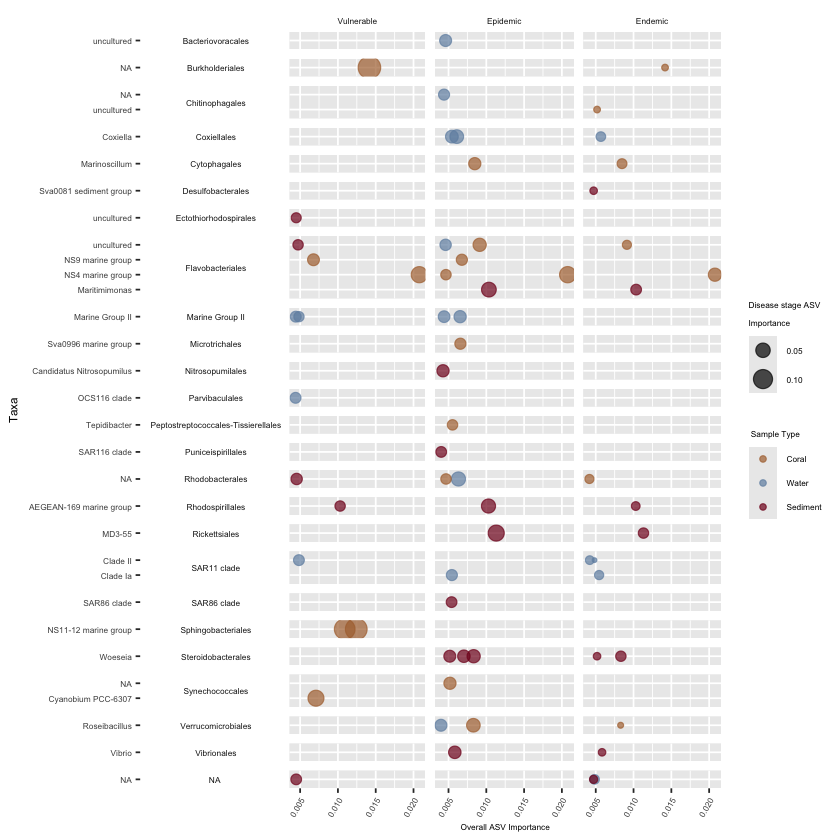

In [53]:
rf_all$Site.Status <- factor(rf_all$Site.Status, levels = c("Vulnerable",
                                                         "Epidemic","Endemic"))
rf_all$Type <- factor(rf_all$Type, levels = c("Coral", "Water", "Sediment"))
rf_all%>%
filter(all>=0.004)%>%
mutate_if(
                is.character, 
                stringr::str_replace_all, 
                pattern = "o__",
                replacement = "")  %>%

mutate_if(
                is.character, 
                stringr::str_replace_all, 
                pattern = "g__",
                replacement = "")  %>%

mutate_if(
                is.character, 
                stringr::str_replace_all, 
                pattern = "_",
                replacement = " ")  %>%
ggplot(
           aes(x=all, y = Genus)) +
geom_point(aes(
    #shape=Type,
               color=Type, 
    size=variable), 
           alpha=0.7,
           #size=variable
          ) +
scale_color_manual("Taxa", values=c(  "#AD6F3B", "#6F8FAF", "#800020")) +
guides(fill = guide_legend(keywidth = 1, , keyheight =.40, ncol=1)) +
#scale_shape_manual("Site Status", values=c(3, 16, 18)) +
ylab("Taxa") +
xlab("Overall ASV Importance") +
theme_bw() +
facet_grid(Order~Site.Status, space ="free", scales="free", switch="y") +
theme(legend.text =element_text(size=8)) +
theme(legend.title = element_text(size=8),
    # legend.position = "top"
     ) +

  guides(
         color = guide_legend(order = 2, ncol=1, 
         keyheight = unit(0.2, 'inch'),
                             #title.position = "top", 
                              title=" Sample Type"
                             ), 
         size = guide_legend(order = 1, ncol=1,
         #keyheight = unit(0.2, 'inch'),
                             
                             #title.position = "top", 
                              title = "Disease stage ASV\n
Importance"
                             )) +
theme_grey() +

theme(legend.text =element_text(size=5)) +
theme(legend.title = element_text(size=5)) +
theme(axis.title.x = element_text(size = 5)) +
theme(axis.title.y = element_text(size = 7)) +
theme(axis.text.x = element_text(size =5)) +
theme(axis.text.y = element_text(size =5)) +
theme(strip.text.x = element_text(size =5)) +
theme(strip.background = element_rect(fill="white")) +
  theme(strip.background = element_blank()) +
  theme(strip.text.y.left = element_text(angle =0 )) +
theme(axis.text.x = element_text(angle =60, hjust=1)) +
  theme(strip.text.y = element_text(size = 5)) 

ggsave("/Users/stephanie.rosales/Documents/Tissueloss/EPA2/Figures/Supp_Fig2.png",
 width = 5, height = 6, units = "in", dpi=300)





     

In [54]:
## list of ASVs for each sample type
rf_wat_df$ASVs

rf_sed_df$ASVs

rf_coral_df$ASVs

[1] "ASV_138680" "ASV_73703"  "ASV_5514"   "ASV_141729" "ASV_113103"
 [6] "ASV_90264"  "ASV_49981"  "ASV_95517"  "ASV_57692"  "ASV_139407"
[11] "ASV_39380"  "ASV_108430" "ASV_30980"  "ASV_134791" "ASV_18621" 
[16] "ASV_101579" "ASV_71778"  "ASV_141729" "ASV_57692"  "ASV_139407"
[21] "ASV_96345"  "ASV_36076"  "ASV_60341"  "ASV_134829" "ASV_126358"
[26] "ASV_62843"  "ASV_48932"  "ASV_106211" "ASV_30980"  "ASV_42045"

[1] "ASV_3184"   "ASV_20725"  "ASV_97598"  "ASV_17134"  "ASV_45155" 
 [6] "ASV_122395" "ASV_85025"  "ASV_129169" "ASV_49480"  "ASV_138685"
[11] "ASV_27636"  "ASV_90521"  "ASV_108998" "ASV_85025"  "ASV_56668" 
[16] "ASV_5447"   "ASV_133053" "ASV_38772"  "ASV_34485"  "ASV_105839"
[21] "ASV_108998" "ASV_27636"  "ASV_85025"  "ASV_90521"  "ASV_68711" 
[26] "ASV_38772"  "ASV_59196"  "ASV_105839" "ASV_22527"  "ASV_113011"

[1] "ASV_5399"   "ASV_95517"  "ASV_141001" "ASV_111371" "ASV_144743"
 [6] "ASV_144712" "ASV_87142"  "ASV_60305"  "ASV_62223"  "ASV_102396"
[11] "ASV_111371" "ASV_33524"  "ASV_96345"  "ASV_83272"  "ASV_106211"
[16] "ASV_40158"  "ASV_71778"  "ASV_5399"   "ASV_31498"  "ASV_62843" 
[21] "ASV_111371" "ASV_62843"  "ASV_106211" "ASV_87679"  "ASV_33524" 
[26] "ASV_68328"  "ASV_60305"  "ASV_144531" "ASV_10465"  "ASV_23878"